# Testing DoWhy's Limits

In [69]:
# Imports

import numpy as np
import pandas as pd
from dowhy import CausalModel
import dowhy.datasets

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Instrumental Variable Basic Example

<center><img src="./figures/image.png"/></center>

### Continuous Variables

In [4]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)

# instrument
voucher = np.random.normal(2, 1, size=n_points)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher

# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education

#### Without latent variables

- Everything working as expected

In [17]:
# Build dataset
data = pd.DataFrame({
    'U': ability,
    'voucher': voucher,
    'education': education,
    'income': income
})

data.head()

,U,voucher,education,income
0,0.437981,2.107517,10.085549,55.311190
1,-0.563524,1.128452,7.532273,44.539801
2,-5.606169,1.242421,1.086370,4.078366
3,1.965070,4.221157,16.263873,80.088267
4,-4.390619,3.060305,8.036111,37.324841


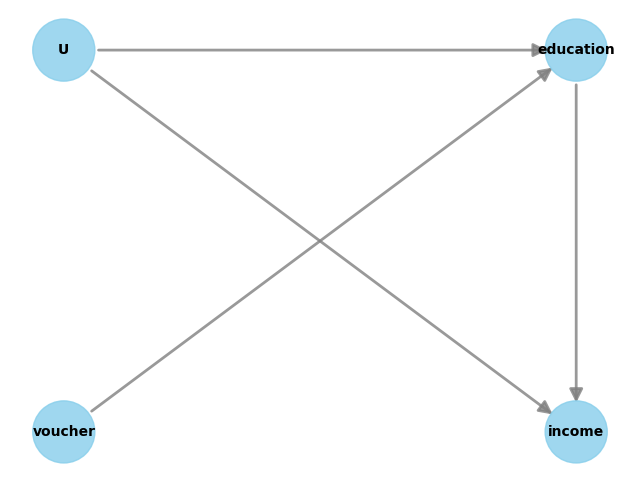

In [19]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [20]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
────────────(E[income|U])
d[education]             
Estimand assumption 1, Unconfoundedness: If U→{education} and U→income then P(income|education,U,U) = P(income|education,U)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [48]:
# Choose the first estimand: using Linear Regression

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:3.971319328422487
New effect:0.005361903839040636
p value:0.96



In [49]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:4.18496818273123
New effect:-0.0026004000929498185
p value:0.98



#### `Ability` as an unobserved confounder

- Everything working as expected
- In this scenario, no backdoor path was identified.
- **Modeling Warning**: *"UserWarning: 1 variables are assumed unobserved because they are not in the dataset."*

In [65]:
# Build dataset
data = pd.DataFrame({
    'voucher': voucher,
    'education': education,
    'income': income
})

data.head()

,voucher,education,income
0,2.107517,10.085549,55.311190
1,1.128452,7.532273,44.539801
2,1.242421,1.086370,4.078366
3,4.221157,16.263873,80.088267
4,3.060305,8.036111,37.324841


c:\Python310\lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


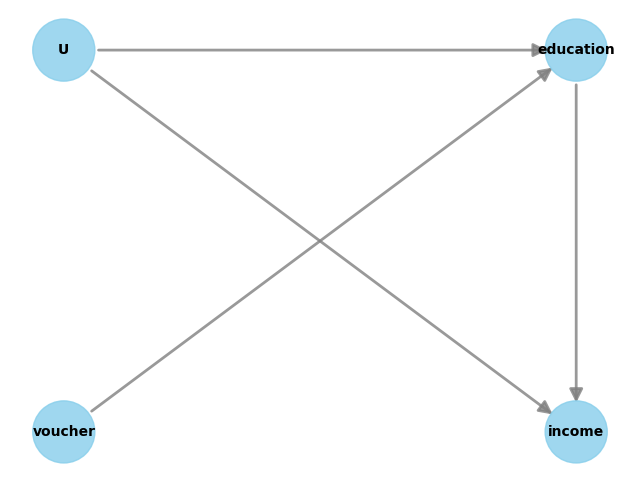

In [66]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [67]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [68]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:4.18496818273123
New effect:-0.026259459954702278
p value:0.88



### Discrete Variables

- Function as continuous variables

In [112]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)

# instrument
voucher = np.random.normal(2, 1, size=n_points)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher


# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education

#### Without latent variables

- Everything working as expected

In [113]:
# Build dataset
data = pd.DataFrame({
    'U': dowhy.datasets.convert_continuous_to_discrete(ability),
    'voucher': dowhy.datasets.convert_continuous_to_discrete(voucher),
    'education': dowhy.datasets.convert_continuous_to_discrete(education),
    'income': dowhy.datasets.convert_continuous_to_discrete(income)
})

data.head()

,U,voucher,education,income
0,0,3,8,38
1,6,3,18,96
2,-4,2,7,32
3,0,1,8,43
4,-4,0,1,8


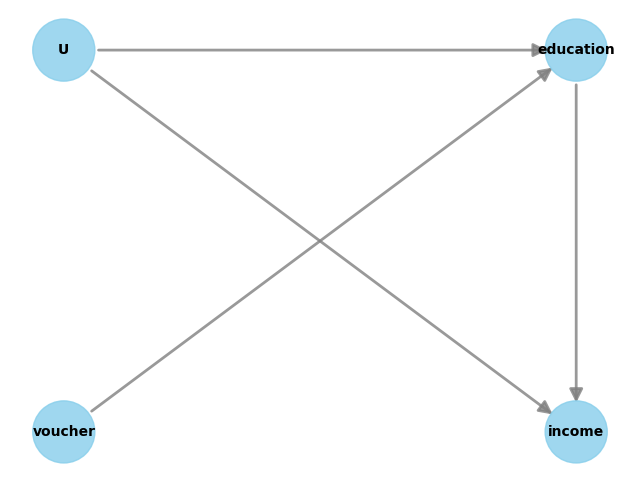

In [114]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [115]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
────────────(E[income|U])
d[education]             
Estimand assumption 1, Unconfoundedness: If U→{education} and U→income then P(income|education,U,U) = P(income|education,U)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [116]:
# Choose the first estimand: using Linear Regression

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:3.950305359824279
New effect:0.0019218825815413964
p value:0.94



In [117]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:4.092985452715136
New effect:-0.04780608020947643
p value:0.86



#### `Ability` as an unobserved confounder

- Everything working as expected
- In this scenario, no backdoor path was identified.
- **Modeling Warning**: *"UserWarning: 1 variables are assumed unobserved because they are not in the dataset."*

In [118]:
# Build dataset
data = pd.DataFrame({
    'voucher': dowhy.datasets.convert_continuous_to_discrete(voucher),
    'education': dowhy.datasets.convert_continuous_to_discrete(education),
    'income': dowhy.datasets.convert_continuous_to_discrete(income)
})

data.head()

,voucher,education,income
0,3,8,38
1,3,18,96
2,2,7,32
3,1,8,43
4,0,1,8


c:\Python310\lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


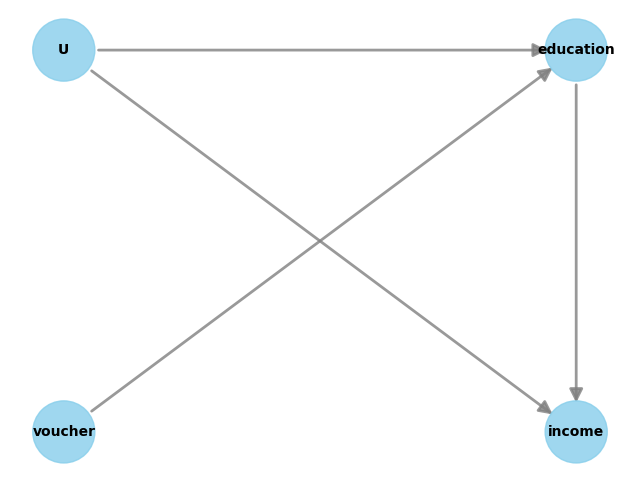

In [119]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [120]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [121]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:4.092985452715136
New effect:-0.00866676018296184
p value:1.0



### Discrete Variables (binary treatment)

- Function as continuous variables

In [126]:
n_points = 1000
education_abilty = 1
education_voucher = 2
income_abilty = 2
income_education = 4


# confounder
ability = np.random.normal(0, 3, size=n_points)

# instrument
voucher = np.random.normal(2, 1, size=n_points)

# treatment
education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
            education_voucher * voucher
education = np.where(education < education.mean(), 0, 1)

# outcome
income = np.random.normal(10, 3, size=n_points) +\
         income_abilty * ability + income_education * education

#### Without latent variables

- IV method only works with non-binary treatment

In [127]:
# Build dataset
data = pd.DataFrame({
    'U': dowhy.datasets.convert_continuous_to_discrete(ability),
    'voucher': dowhy.datasets.convert_continuous_to_discrete(voucher),
    'education': education,
    'income': dowhy.datasets.convert_continuous_to_discrete(income)
})

data.head()

,U,voucher,education,income
0,-2,0,0,10
1,-1,1,1,13
2,3,1,1,24
3,2,2,1,20
4,3,1,1,21


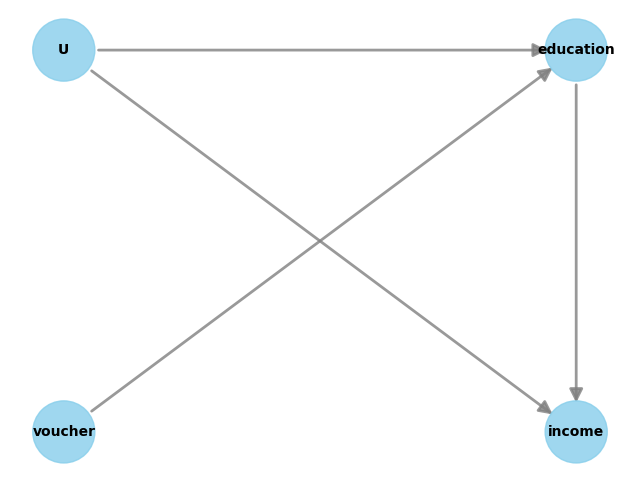

In [128]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [129]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                   
────────────(E[income|U])
d[education]             
Estimand assumption 1, Unconfoundedness: If U→{education} and U→income then P(income|education,U,U) = P(income|education,U)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [141]:
# Choose the first estimand: using Linear Regression

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:3.993392548022479
New effect:-0.013638287132116496
p value:0.94



In [142]:
# Choose the first estimand: using Propensity Score Stratification

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:4.230154518613968
New effect:-0.03047869389189346
p value:0.92



In [136]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", test_significance=True)

print(estimate)

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
  ⎡   d            ⎤  
 E⎢────────(income)⎥  
  ⎣dvoucher        ⎦  
──────────────────────
 ⎡   d               ⎤
E⎢────────(education)⎥
 ⎣dvoucher           ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)
Estimand assumption 3,

#### `Ability` as an unobserved confounder

- Everything working as expected
- In this scenario, no backdoor path was identified.
- **Modeling Warning**: *"UserWarning: 1 variables are assumed unobserved because they are not in the dataset."*

In [143]:
# Build dataset
data = pd.DataFrame({
    'voucher': dowhy.datasets.convert_continuous_to_discrete(voucher),
    'education': education,
    'income': dowhy.datasets.convert_continuous_to_discrete(income)
})

data.head()

,voucher,education,income
0,0,0,10
1,1,1,13
2,1,1,24
3,2,1,20
4,1,1,21


c:\Python310\lib\site-packages\dowhy\causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


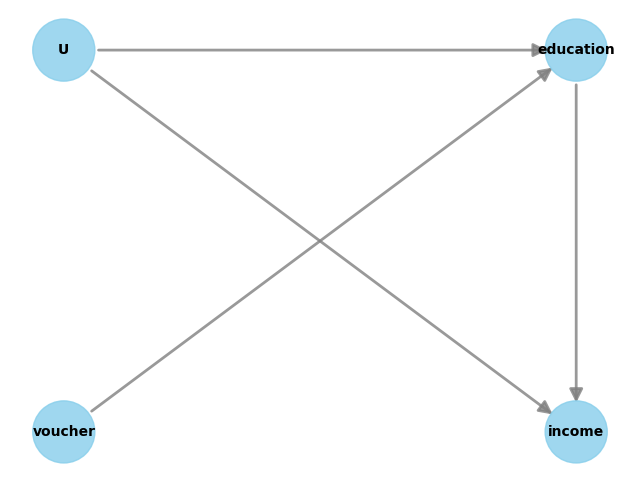

In [144]:
#Step 1: Model
model=CausalModel(
        data = data,
        treatment='education',
        outcome='income',
        common_causes=['U'],
        instruments=['voucher']
        )
model.view_model()

In [ ]:
# Step 2: Identify
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢    d              ⎛    d                  ⎞  ⎥
E⎢──────────(income)⋅⎜──────────([education])⎟  ⎥
 ⎣d[voucher]         ⎝d[voucher]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→income then ¬(U →→{voucher})
Estimand assumption 2, Exclusion: If we remove {voucher}→{education}, then ¬({voucher}→income)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [ ]:
# Choose the second estimand: using IV

# Step 3: Estimate
estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable")

# Step 4: Refute
ref = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(ref)


Refute: Use a Placebo Treatment
Estimated effect:4.092985452715136
New effect:-0.00866676018296184
p value:1.0

